### Comparing the unbound pred with the cutoff pred: 
* Any associations in or different strength in unbound compared to in cutoff?

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from ptitprince import PtitPrince as pt
import os

In [2]:
pd.set_option('display.max_columns', 200)

In [3]:
basedir = '/scratch/ias41/ae_code'

In [4]:
with open(basedir + '/analysis/data/dirs_info.pkl', 'rb') as f:
    dirs = pickle.load(f)
    
faers_data_unbound = dirs['20200110_faers_unbound_margin_pred_005_PRR2']
sider_data_unbound = dirs['20200110_sider_unbound_margin_pred']
faers_data_cutoff = dirs['20200110_faers_cutoff6_pred_005_PRR2']
sider_data_cutoff = dirs['20200110_sider_cutoff6_pred']

In [5]:
# Target information
target_info = pd.read_csv(basedir + '/ae_target_links/data/target_names.txt', sep='\t')
target_info = target_info.loc[target_info['accession_organism']=='Homo sapiens',:]

# Previously reported associations
# Known associations, merge with known hierarchy HLT
known_associations = pd.read_excel(basedir + '/prev_reported_safety_associations/data/safety_meddra_annotated_effects.xls')
known_associations['Annotated MedDRA PT'] = known_associations['Annotated MedDRA PT'].apply(lambda x: x.upper())
known_meddra_hier = pd.read_excel(basedir + '/prev_reported_safety_associations/data/safety_meddra_annotated_effects_for_hierarchy_output.xlsx', skiprows=4)
known_meddra_hier['PT'] = known_meddra_hier['PT'].apply(lambda x: x.upper())
known_meddra_hier[' Term'] = known_meddra_hier[' Term'].apply(lambda x: x.upper())
known_meddra_hier['HLT'] = known_meddra_hier['HLT'].apply(lambda x: x.upper())
known_meddra_hier_selection = known_meddra_hier.loc[known_meddra_hier['Primary SOC']=='Y',['PT','HLT',' Term']].drop_duplicates()
known_merged = known_associations.merge(known_meddra_hier_selection, left_on='Annotated MedDRA PT', right_on=' Term')

hlt_manual = pd.read_excel(basedir + '/prev_reported_safety_associations/data/safety_meddra_manually_annotated_hlt_effects.xls', index=False)
hlt_manual.rename(columns={'Annotated MedDRA HLT': 'HLT'}, inplace=True)
hlt_manual['HLT'] = hlt_manual['HLT'].apply(lambda x: x.upper())
hlt_manual.drop(columns=['Annotated MedDRA HLT Code'])

known_merged = pd.concat([known_merged, hlt_manual], sort=False).reset_index(drop=True)

# MedDRA hierchy
meddra_hier = pd.read_excel(basedir + '/analysis/data/all_faers_and_sider_aes_hier_output.xlsx', skiprows=4)
meddra_hier_selection = meddra_hier.loc[meddra_hier['Primary SOC']=='Y',[' Term','HLT','SOC','PT']].drop_duplicates()
meddra_hier_selection['HLT'] = meddra_hier_selection['HLT'].apply(lambda x: x.upper())

# Known associations
known_hlt_tuples = set([(x[1]['Accession'], x[1]['HLT']) for x in known_merged.iterrows()])
known_pt_tuples = set([(x[1]['Accession'], x[1]['PT']) for x in known_merged.loc[~known_merged['PT'].isnull()].iterrows()])

In [6]:
faers_perf_unbound = pd.read_csv(basedir + '/ae_target_links/output/' + faers_data_unbound['dir'] + '/sign_assoc_performance.txt', sep='\t')
sider_perf_unbound = pd.read_csv(basedir + '/ae_target_links/output/' + sider_data_unbound['dir'] + '/sign_assoc_performance.txt', sep='\t')
faers_perf_cutoff = pd.read_csv(basedir + '/ae_target_links/output/' + faers_data_cutoff['dir'] + '/sign_assoc_performance.txt', sep='\t')
sider_perf_cutoff = pd.read_csv(basedir + '/ae_target_links/output/' + sider_data_cutoff['dir'] + '/sign_assoc_performance.txt', sep='\t')

In [7]:
faers_perf_unbound_pos = pd.read_csv(basedir + '/ae_target_links/output/' + faers_data_unbound['dir'] + '/pos_assoc_performance.txt', sep='\t')
sider_perf_unbound_pos = pd.read_csv(basedir + '/ae_target_links/output/' + sider_data_unbound['dir'] + '/pos_assoc_performance.txt', sep='\t')
faers_perf_cutoff_pos = pd.read_csv(basedir + '/ae_target_links/output/' + faers_data_cutoff['dir'] + '/pos_assoc_performance.txt', sep='\t')
sider_perf_cutoff_pos = pd.read_csv(basedir + '/ae_target_links/output/' + sider_data_cutoff['dir'] + '/pos_assoc_performance.txt', sep='\t')

In [8]:
faers_perf_unbound_merged = faers_perf_unbound.merge(meddra_hier_selection, left_on='Adverse Event', right_on=' Term')
sider_perf_unbound_merged = sider_perf_unbound.merge(meddra_hier_selection, left_on='Adverse Event', right_on=' Term')
faers_perf_cutoff_merged = faers_perf_cutoff.merge(meddra_hier_selection, left_on='Adverse Event', right_on=' Term')
sider_perf_cutoff_merged = sider_perf_cutoff.merge(meddra_hier_selection, left_on='Adverse Event', right_on=' Term')

In [9]:
faers_perf_unbound_pos_merged = faers_perf_unbound_pos.merge(meddra_hier_selection, left_on='Adverse Event', right_on=' Term')
sider_perf_unbound_pos_merged = sider_perf_unbound_pos.merge(meddra_hier_selection, left_on='Adverse Event', right_on=' Term')
faers_perf_cutoff_pos_merged = faers_perf_cutoff_pos.merge(meddra_hier_selection, left_on='Adverse Event', right_on=' Term')
sider_perf_cutoff_pos_merged = sider_perf_cutoff_pos.merge(meddra_hier_selection, left_on='Adverse Event', right_on=' Term')

In [10]:
def find_pt_known(row):
    if ((row['accession'],row['Adverse Event'])) in known_pt_tuples:
        return 1
    else:
        return 0

def find_hlt_known(row):
    if ((row['accession'],row['HLT'])) in known_hlt_tuples:
        return 1
    else:
        return 0

for df in [faers_perf_unbound_merged, sider_perf_unbound_merged, faers_perf_cutoff_merged, sider_perf_cutoff_merged]:
    df['known_pt'] = df.apply(find_pt_known, axis=1)
    df['known_hlt'] = df.apply(find_hlt_known, axis=1)

In [11]:
for df in [faers_perf_unbound_pos_merged, sider_perf_unbound_pos_merged, faers_perf_cutoff_pos_merged, sider_perf_cutoff_pos_merged]:
    df['known_pt'] = df.apply(find_pt_known, axis=1)
    df['known_hlt'] = df.apply(find_hlt_known, axis=1)

In [12]:
len(faers_perf_unbound_merged.loc[faers_perf_unbound_merged['known_hlt']==1]), len(faers_perf_cutoff_merged.loc[faers_perf_cutoff_merged['known_hlt']==1])

(11, 12)

In [13]:
len(sider_perf_unbound_merged.loc[sider_perf_unbound_merged['known_hlt']==1]), len(sider_perf_cutoff_merged.loc[sider_perf_cutoff_merged['known_hlt']==1])

(22, 68)

In [83]:
faers_perf_unbound_merged.loc[faers_perf_unbound_merged['pref_name']=='HERG']

,accession,nr compounds,nr compounds with AE,ae_hit_rate,nr compounds without AE,nae_hit_rate,nr compounds active,nr compounds inactive,Adverse Event,Likelihood Ratio,p-value,activity_vector,ae_vector,molregnos,active_molregnos,predicted_vector,corrected p-value,tid,pref_name,target_type,accession_organism,target_organism,PPV,ae_prevalence,specificity,PRU,improvement_over_prevalence,Term,HLT,SOC,PT,known_pt,known_hlt
216,Q12809,475,40,0.175,435,0.018391,15.0,460.0,TORSADE DE POINTES,9.515625,0.00007,"[0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, ...","[97, 605, 1219, 1278, 1325, 2223, 2261, 2580, ...","[1219, 2580, 3183, 3859, 5638, 5970, 6579, 125...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.045806,165.0,HERG,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.466667,0.084211,0.981609,0.417625,0.382456,TORSADE DE POINTES,VENTRICULAR ARRHYTHMIAS AND CARDIAC ARREST,Cardiac disorders,Torsade de pointes,0,0


In [15]:
faers_perf_cutoff_merged.loc[faers_perf_cutoff_merged['pref_name']=='HERG']

,accession,nr compounds,nr compounds with AE,ae_hit_rate,nr compounds without AE,nae_hit_rate,nr compounds active,nr compounds inactive,Adverse Event,Likelihood Ratio,p-value,activity_vector,ae_vector,molregnos,active_molregnos,predicted_vector,corrected p-value,tid,pref_name,target_type,accession_organism,target_organism,PPV,ae_prevalence,specificity,PRU,improvement_over_prevalence,Term,HLT,SOC,PT,known_pt,known_hlt


In [16]:
sider_perf_unbound_merged.loc[sider_perf_unbound_merged['pref_name']=='HERG']

,accession,nr compounds,nr compounds with AE,ae_hit_rate,nr compounds without AE,nae_hit_rate,nr compounds active,nr compounds inactive,Adverse Event,Likelihood Ratio,p-value,activity_vector,ae_vector,molregnos,active_molregnos,predicted_vector,corrected p-value,tid,pref_name,target_type,accession_organism,target_organism,PPV,ae_prevalence,specificity,PRU,improvement_over_prevalence,Term,HLT,SOC,PT,known_pt,known_hlt
284,Q12809,371,19,0.263158,352,0.019886,12.0,359.0,VENTRICULAR ARRHYTHMIA,13.233083,0.000129,"[0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, ...","[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[97, 1219, 1278, 1325, 2223, 2580, 3183, 3599,...","[1219, 2580, 3183, 3859, 5638, 6579, 12506, 12...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.030232,165,HERG,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.416667,0.051213,0.980114,0.38518,0.365454,VENTRICULAR ARRHYTHMIA,VENTRICULAR ARRHYTHMIAS AND CARDIAC ARREST,Cardiac disorders,Ventricular arrhythmia,0,0


In [17]:
sider_perf_cutoff_merged.loc[sider_perf_cutoff_merged['pref_name']=='HERG']

,accession,nr compounds,nr compounds with AE,ae_hit_rate,nr compounds without AE,nae_hit_rate,nr compounds active,nr compounds inactive,Adverse Event,Likelihood Ratio,p-value,activity_vector,ae_vector,molregnos,active_molregnos,predicted_vector,corrected p-value,tid,pref_name,target_type,accession_organism,target_organism,PPV,ae_prevalence,specificity,PRU,improvement_over_prevalence,Term,HLT,SOC,PT,known_pt,known_hlt
1396,Q12809,384,9,0.444444,375,0.034667,17.0,367.0,ELECTROCARDIOGRAM QT PROLONGED,12.820513,0.000293,"[0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...","[97, 1219, 1278, 1325, 2223, 2580, 3183, 3599,...","[1219, 2580, 3183, 3859, 5638, 6968, 7714, 124...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.023700,165.0,HERG,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.235294,0.023438,0.965333,0.216941,0.211857,ELECTROCARDIOGRAM QT PROLONGED,ECG INVESTIGATIONS,Investigations,Electrocardiogram QT prolonged,1,1
2114,Q12809,384,25,0.280000,359,0.027855,17.0,367.0,VENTRICULAR TACHYCARDIA,10.052000,0.000026,"[0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, ...","[97, 1219, 1278, 1325, 2223, 2580, 3183, 3599,...","[1219, 2580, 3183, 3859, 5638, 6968, 7714, 124...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.008522,165.0,HERG,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.411765,0.065104,0.972145,0.370801,0.346661,VENTRICULAR TACHYCARDIA,VENTRICULAR ARRHYTHMIAS AND CARDIAC ARREST,Cardiac disorders,Ventricular tachycardia,0,0
2115,Q12809,384,14,0.357143,370,0.032432,17.0,367.0,TORSADE DE POINTES,11.011905,0.000143,"[0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, ...","[97, 1219, 1278, 1325, 2223, 2580, 3183, 3599,...","[1219, 2580, 3183, 3859, 5638, 6968, 7714, 124...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.015495,165.0,HERG,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.294118,0.036458,0.967568,0.267409,0.257659,TORSADE DE POINTES,VENTRICULAR ARRHYTHMIAS AND CARDIAC ARREST,Cardiac disorders,Torsade de pointes,0,0
2116,Q12809,384,21,0.285714,363,0.030303,17.0,367.0,VENTRICULAR ARRHYTHMIA,9.428571,0.000107,"[0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[97, 1219, 1278, 1325, 2223, 2580, 3183, 3599,...","[1219, 2580, 3183, 3859, 5638, 6968, 7714, 124...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.015495,165.0,HERG,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.352941,0.054688,0.969697,0.315508,0.298254,VENTRICULAR ARRHYTHMIA,VENTRICULAR ARRHYTHMIAS AND CARDIAC ARREST,Cardiac disorders,Ventricular arrhythmia,0,0


In [18]:
faers_perf_unbound_merged.loc[(faers_perf_unbound_merged['pref_name'].str.contains('2b'))&(faers_perf_unbound_merged['Adverse Event'].str.contains('CARDIO'))]

,accession,nr compounds,nr compounds with AE,ae_hit_rate,nr compounds without AE,nae_hit_rate,nr compounds active,nr compounds inactive,Adverse Event,Likelihood Ratio,p-value,activity_vector,ae_vector,molregnos,active_molregnos,predicted_vector,corrected p-value,tid,pref_name,target_type,accession_organism,target_organism,PPV,ae_prevalence,specificity,PRU,improvement_over_prevalence,Term,HLT,SOC,PT,known_pt,known_hlt
99,P41595,442,21,0.333333,421,0.061758,33.0,409.0,CARDIOTOXICITY,5.397436,0.000374,"[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, ...","[0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[97, 573, 996, 1219, 1370, 1785, 2203, 2261, 2...","[573, 996, 1219, 1370, 1785, 2261, 2262, 3183,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.048521,227.0,Serotonin 2b (5-HT2b) receptor,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.212121,0.047511,0.938242,0.172821,0.16461,CARDIOTOXICITY,CARDIAC DISORDERS NEC,Cardiac disorders,Cardiotoxicity,0,0
104,P41595,442,21,0.380952,421,0.059382,33.0,409.0,ELECTROCARDIOGRAM QRS COMPLEX PROLONGED,6.415238,0.000042,"[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, ...","[0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[97, 573, 996, 1219, 1370, 1785, 2203, 2261, 2...","[573, 996, 1219, 1370, 1785, 2261, 2262, 3183,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.027177,227.0,Serotonin 2b (5-HT2b) receptor,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.212121,0.047511,0.940618,0.172821,0.16461,ELECTROCARDIOGRAM QRS COMPLEX PROLONGED,ECG INVESTIGATIONS,Investigations,Electrocardiogram QRS complex prolonged,0,0


In [19]:
faers_perf_cutoff_merged.loc[faers_perf_cutoff_merged['pref_name'].str.contains('Serotonin 2b')]

,accession,nr compounds,nr compounds with AE,ae_hit_rate,nr compounds without AE,nae_hit_rate,nr compounds active,nr compounds inactive,Adverse Event,Likelihood Ratio,p-value,activity_vector,ae_vector,molregnos,active_molregnos,predicted_vector,corrected p-value,tid,pref_name,target_type,accession_organism,target_organism,PPV,ae_prevalence,specificity,PRU,improvement_over_prevalence,Term,HLT,SOC,PT,known_pt,known_hlt


In [20]:
sider_perf_unbound_merged.loc[sider_perf_unbound_merged['pref_name'].str.contains('Serotonin 2b')]

,accession,nr compounds,nr compounds with AE,ae_hit_rate,nr compounds without AE,nae_hit_rate,nr compounds active,nr compounds inactive,Adverse Event,Likelihood Ratio,p-value,activity_vector,ae_vector,molregnos,active_molregnos,predicted_vector,corrected p-value,tid,pref_name,target_type,accession_organism,target_organism,PPV,ae_prevalence,specificity,PRU,improvement_over_prevalence,Term,HLT,SOC,PT,known_pt,known_hlt
75,P41595,345,8,0.625,337,0.04451,20.0,325.0,TARDIVE DYSKINESIA,14.041667,0.00002,"[0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...","[97, 573, 1219, 1370, 1785, 2203, 3183, 3599, ...","[573, 1219, 1370, 1785, 3183, 6216, 7714, 1181...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.004922,227,Serotonin 2b (5-HT2b) receptor,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.25,0.023188,0.95549,0.232196,0.226812,TARDIVE DYSKINESIA,DYSKINESIAS AND MOVEMENT DISORDERS NEC,Nervous system disorders,Tardive dyskinesia,0,0


In [21]:
sider_perf_cutoff_merged.loc[sider_perf_cutoff_merged['pref_name'].str.contains('Serotonin 2b')]

,accession,nr compounds,nr compounds with AE,ae_hit_rate,nr compounds without AE,nae_hit_rate,nr compounds active,nr compounds inactive,Adverse Event,Likelihood Ratio,p-value,activity_vector,ae_vector,molregnos,active_molregnos,predicted_vector,corrected p-value,tid,pref_name,target_type,accession_organism,target_organism,PPV,ae_prevalence,specificity,PRU,improvement_over_prevalence,Term,HLT,SOC,PT,known_pt,known_hlt
374,P41595,372,16,0.500000,356,0.084270,38.0,334.0,NEUROLEPTIC MALIGNANT SYNDROME,5.933333,0.000040,"[0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, ...","[97, 573, 1219, 1370, 1785, 2203, 2208, 3183, ...","[573, 1219, 1370, 2203, 2208, 3183, 3599, 6216...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.007789,227.0,Serotonin 2b (5-HT2b) receptor,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.210526,0.043011,0.915730,0.175044,0.167516,NEUROLEPTIC MALIGNANT SYNDROME,MUSCLE TONE ABNORMAL,Nervous system disorders,Neuroleptic malignant syndrome,0,0
445,P41595,372,9,0.666667,363,0.088154,38.0,334.0,TARDIVE DYSKINESIA,7.562500,0.000052,"[0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[97, 573, 1219, 1370, 1785, 2203, 2208, 3183, ...","[573, 1219, 1370, 2203, 2208, 3183, 3599, 6216...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.007789,227.0,Serotonin 2b (5-HT2b) receptor,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.157895,0.024194,0.911846,0.137016,0.133701,TARDIVE DYSKINESIA,DYSKINESIAS AND MOVEMENT DISORDERS NEC,Nervous system disorders,Tardive dyskinesia,0,0


In [22]:
faers_perf_unbound_merged.loc[(faers_perf_unbound_merged['pref_name'].str.contains('D2'))&(faers_perf_unbound_merged['Adverse Event'].str.contains('GYN'))]

,accession,nr compounds,nr compounds with AE,ae_hit_rate,nr compounds without AE,nae_hit_rate,nr compounds active,nr compounds inactive,Adverse Event,Likelihood Ratio,p-value,activity_vector,ae_vector,molregnos,active_molregnos,predicted_vector,corrected p-value,tid,pref_name,target_type,accession_organism,target_organism,PPV,ae_prevalence,specificity,PRU,improvement_over_prevalence,Term,HLT,SOC,PT,known_pt,known_hlt


In [23]:
faers_perf_unbound_merged.loc[(faers_perf_unbound_merged['pref_name'].str.contains('D2'))&(faers_perf_unbound_merged['Adverse Event'].str.contains('GALAC'))]

,accession,nr compounds,nr compounds with AE,ae_hit_rate,nr compounds without AE,nae_hit_rate,nr compounds active,nr compounds inactive,Adverse Event,Likelihood Ratio,p-value,activity_vector,ae_vector,molregnos,active_molregnos,predicted_vector,corrected p-value,tid,pref_name,target_type,accession_organism,target_organism,PPV,ae_prevalence,specificity,PRU,improvement_over_prevalence,Term,HLT,SOC,PT,known_pt,known_hlt
194,P14416,473,6,0.666667,467,0.049251,27.0,446.0,GALACTORRHOEA,13.536232,0.000118,"[0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[573, 605, 996, 1333, 2203, 2261, 3599, 3859, ...","[605, 996, 1333, 2261, 3859, 5970, 6216, 7714,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.016284,72.0,Dopamine D2 receptor,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.148148,0.012685,0.950749,0.137204,0.135463,GALACTORRHOEA,LACTATION DISORDERS,Reproductive system and breast disorders,Galactorrhoea,0,0


In [24]:
faers_perf_cutoff_merged.loc[(faers_perf_cutoff_merged['pref_name'].str.contains('D2'))&(faers_perf_cutoff_merged['Adverse Event'].str.contains('GALAC'))]

,accession,nr compounds,nr compounds with AE,ae_hit_rate,nr compounds without AE,nae_hit_rate,nr compounds active,nr compounds inactive,Adverse Event,Likelihood Ratio,p-value,activity_vector,ae_vector,molregnos,active_molregnos,predicted_vector,corrected p-value,tid,pref_name,target_type,accession_organism,target_organism,PPV,ae_prevalence,specificity,PRU,improvement_over_prevalence,Term,HLT,SOC,PT,known_pt,known_hlt


In [25]:
sider_perf_unbound_merged.loc[(sider_perf_unbound_merged['pref_name'].str.contains('D2'))&(sider_perf_unbound_merged['Adverse Event'].str.contains('GALAC'))]

,accession,nr compounds,nr compounds with AE,ae_hit_rate,nr compounds without AE,nae_hit_rate,nr compounds active,nr compounds inactive,Adverse Event,Likelihood Ratio,p-value,activity_vector,ae_vector,molregnos,active_molregnos,predicted_vector,corrected p-value,tid,pref_name,target_type,accession_organism,target_organism,PPV,ae_prevalence,specificity,PRU,improvement_over_prevalence,Term,HLT,SOC,PT,known_pt,known_hlt
290,P14416,374,16,0.25,358,0.030726,15.0,359.0,GALACTORRHOEA,8.136364,0.002315,"[0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...","[573, 2203, 3599, 3859, 6216, 6968, 7065, 7714...","[3859, 6216, 7714, 16505, 19316, 27368, 33664,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.020335,72,Dopamine D2 receptor,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.266667,0.042781,0.969274,0.233892,0.223886,GALACTORRHOEA,LACTATION DISORDERS,Reproductive system and breast disorders,Galactorrhoea,0,0


In [26]:
sider_perf_cutoff_merged.loc[(sider_perf_cutoff_merged['pref_name'].str.contains('D2'))&(sider_perf_cutoff_merged['Adverse Event'].str.contains('GALAC'))]

,accession,nr compounds,nr compounds with AE,ae_hit_rate,nr compounds without AE,nae_hit_rate,nr compounds active,nr compounds inactive,Adverse Event,Likelihood Ratio,p-value,activity_vector,ae_vector,molregnos,active_molregnos,predicted_vector,corrected p-value,tid,pref_name,target_type,accession_organism,target_organism,PPV,ae_prevalence,specificity,PRU,improvement_over_prevalence,Term,HLT,SOC,PT,known_pt,known_hlt


### Some Qs

In [80]:
faers_perf_unbound_merged.loc[faers_perf_unbound_merged['SOC'].str.contains('Metabo'),['Adverse Event','pref_name']]

,Adverse Event,pref_name
16,DIABETIC COMPLICATION,Alpha-1a adrenergic receptor
17,DIABETIC COMPLICATION,Serotonin 2a (5-HT2a) receptor
18,DIABETIC COMPLICATION,Serotonin 2b (5-HT2b) receptor
19,DIABETIC COMPLICATION,Dopamine D4 receptor
20,DIABETIC COMPLICATION,Alpha-1b adrenergic receptor
21,DIABETIC COMPLICATION,Alpha-2c adrenergic receptor
22,DIABETIC COMPLICATION,Dopamine D2 receptor
23,DIABETIC COMPLICATION,Serotonin 7 (5-HT7) receptor
38,INSULIN-REQUIRING TYPE 2 DIABETES MELLITUS,Alpha-1a adrenergic receptor
39,INSULIN-REQUIRING TYPE 2 DIABETES MELLITUS,Dopamine D3 receptor


In [79]:
sider_perf_unbound_merged.loc[sider_perf_unbound_merged['SOC'].str.contains('Metabo'),['Adverse Event','pref_name']]

,Adverse Event,pref_name
172,HYPOGLYCAEMIA,Sigma opioid receptor
173,HYPOGLYCAEMIA,Dopamine D2 receptor
174,HYPOGLYCAEMIA,Alpha-1d adrenergic receptor
182,METABOLIC ACIDOSIS,Carbonic anhydrase IV
183,METABOLIC ACIDOSIS,Carbonic anhydrase IX
184,METABOLIC ACIDOSIS,Carbonic anhydrase VB
185,METABOLIC ACIDOSIS,Carbonic anhydrase VII
186,METABOLIC ACIDOSIS,Carbonic anhydrase VA
187,HYPOKALAEMIA,Carbonic anhydrase IV
188,HYPOKALAEMIA,Carbonic anhydrase IX


In [81]:
faers_perf_unbound_merged.loc[faers_perf_unbound_merged['SOC'].str.contains('Investi'),['Adverse Event','pref_name']]

,Adverse Event,pref_name
0,TOTAL LUNG CAPACITY DECREASED,Carbonic anhydrase II
102,ELECTROCARDIOGRAM QRS COMPLEX PROLONGED,Serotonin transporter
103,ELECTROCARDIOGRAM QRS COMPLEX PROLONGED,Serotonin 2a (5-HT2a) receptor
104,ELECTROCARDIOGRAM QRS COMPLEX PROLONGED,Serotonin 2b (5-HT2b) receptor
105,ELECTROCARDIOGRAM QRS COMPLEX PROLONGED,Serotonin 2c (5-HT2c) receptor
185,BLOOD PROLACTIN INCREASED,Serotonin 2a (5-HT2a) receptor


In [82]:
sider_perf_unbound_merged.loc[sider_perf_unbound_merged['SOC'].str.contains('Investi'),['Adverse Event','pref_name']]

,Adverse Event,pref_name
249,BLOOD URIC ACID INCREASED,Carbonic anhydrase VB
250,BLOOD URIC ACID INCREASED,Carbonic anhydrase VA


### What % is retrieved overall? Datasets combined

##### Need to find all associations to know which targets and AEs are in dataset

In [27]:
def find_all_associations(output_dir, min_n=None):
    plt.rcdefaults()

    all_associations = pd.DataFrame()
    files = [i for i in os.listdir(output_dir + '/data') if 'ratios_all.txt' in i]

    # Loop over all targets
    for file in files:  
        target_df = pd.read_csv(output_dir + '/data/{}'.format(file), sep='\t')

        if len(target_df) < 1:
            continue

        all_associations = all_associations.append(target_df)
    
    if min_n:
        all_associations = all_associations.loc[(all_associations['nr compounds with AE']>=min_n)&(all_associations['nr compounds active']>=min_n)&(~all_associations['Likelihood Ratio'].isnull()),:]
    
    return all_associations

In [28]:
all_associations_faers_unbound = find_all_associations(basedir + '/ae_target_links/output/20200110_faers_unbound_margin_pred_005_PRR2', min_n=5).merge(meddra_hier_selection, left_on='Adverse Event', right_on=' Term')
all_associations_sider_unbound = find_all_associations(basedir + '/ae_target_links/output/20200110_sider_unbound_margin_pred', min_n=5).merge(meddra_hier_selection, left_on='Adverse Event', right_on=' Term')
all_associations_faers_cutoff = find_all_associations(basedir + '/ae_target_links/output/20200110_faers_cutoff6_pred_005_PRR2', min_n=5).merge(meddra_hier_selection, left_on='Adverse Event', right_on=' Term')
all_associations_sider_cutoff = find_all_associations(basedir + '/ae_target_links/output/20200110_sider_cutoff6_pred', min_n=5).merge(meddra_hier_selection, left_on='Adverse Event', right_on=' Term')

In [29]:
combined_all_unbound = pd.concat([all_associations_faers_unbound, all_associations_sider_unbound])
combined_all_cutoff = pd.concat([all_associations_faers_cutoff, all_associations_sider_cutoff])

In [30]:
combined_unbound = pd.concat([sider_perf_unbound_merged, faers_perf_unbound_merged])
combined_cutoff = pd.concat([sider_perf_cutoff_merged, faers_perf_cutoff_merged])

In [31]:
# Total number of known associations for targets/AEs in dataset - unbound

len(known_merged.loc[(known_merged['Accession'].isin(combined_all_unbound['accession']))&(known_merged['HLT'].isin(combined_all_unbound['HLT'])), ['Accession', 'HLT']].drop_duplicates())

483

In [32]:
# Total number of known associations for targets/AEs in dataset - cutoff

len(known_merged.loc[(known_merged['Accession'].isin(combined_all_cutoff['accession']))&(known_merged['HLT'].isin(combined_all_cutoff['HLT'])), ['Accession', 'HLT']].drop_duplicates())

539

In [33]:
# Nr associations retrieved unbound - different from 33 because of overlap FAERS & SIDER
len(combined_unbound.loc[combined_unbound['known_hlt']==1,['accession','Adverse Event']].drop_duplicates()) 

32

In [34]:
# Nr associations retrieved cutoff - different from 33 because of overlap FAERS & SIDER
len(combined_cutoff.loc[combined_cutoff['known_hlt']==1,['accession','Adverse Event']].drop_duplicates())

77

In [35]:
# % retrieved unbound
(len(combined_unbound.loc[combined_unbound['known_hlt']==1,['accession','HLT']].drop_duplicates()) / len(known_merged.loc[(known_merged['Accession'].isin(combined_all_unbound['accession']))&(known_merged['HLT'].isin(combined_all_unbound['HLT'])), ['Accession', 'HLT']].drop_duplicates())) * 100

5.590062111801243

In [36]:
# % retrieved cutoff
(len(combined_cutoff.loc[combined_cutoff['known_hlt']==1,['accession','HLT']].drop_duplicates()) / len(known_merged.loc[(known_merged['Accession'].isin(combined_all_cutoff['accession']))&(known_merged['HLT'].isin(combined_all_cutoff['HLT'])), ['Accession', 'HLT']].drop_duplicates())) * 100

11.688311688311687

### Overlap in associations between unbound and cutoff

Known associations:
Associations in unbound but not in cut-off, FAERS

In [37]:
unbound_set_faers = set([(x[1]['accession'], x[1]['HLT']) for x in faers_perf_unbound_merged.loc[faers_perf_unbound_merged['known_hlt']==1].iterrows()])
cutoff_set_faers = set([(x[1]['accession'], x[1]['HLT']) for x in faers_perf_cutoff_merged.loc[faers_perf_cutoff_merged['known_hlt']==1].iterrows()])

In [38]:
unbound_set_faers - cutoff_set_faers

{('P28223', 'NEUROLOGICAL SIGNS AND SYMPTOMS NEC'),
 ('P31645', 'NEUROLOGICAL SIGNS AND SYMPTOMS NEC'),
 ('P35348', 'NEUROLOGICAL SIGNS AND SYMPTOMS NEC'),
 ('P35348', 'VASCULAR HYPOTENSIVE DISORDERS'),
 ('P35368', 'VASCULAR HYPOTENSIVE DISORDERS'),
 ('P35372', 'SUBSTANCE RELATED AND ADDICTIVE DISORDERS')}

In [39]:
faers_perf_unbound_merged.loc[(faers_perf_unbound_merged['accession'].isin(['P31645', 'P28223', 'P35348']))&(faers_perf_unbound_merged['HLT']=='NEUROLOGICAL SIGNS AND SYMPTOMS NEC')]

,accession,nr compounds,nr compounds with AE,ae_hit_rate,nr compounds without AE,nae_hit_rate,nr compounds active,nr compounds inactive,Adverse Event,Likelihood Ratio,p-value,activity_vector,ae_vector,molregnos,active_molregnos,predicted_vector,corrected p-value,tid,pref_name,target_type,accession_organism,target_organism,PPV,ae_prevalence,specificity,PRU,improvement_over_prevalence,Term,HLT,SOC,PT,known_pt,known_hlt
92,P35348,375,8,0.375000,367,0.021798,11.0,364.0,GRIMACING,17.203125,0.000977,"[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...","[97, 2261, 3859, 7714, 23093, 33373, 33664, 33...","[97, 2261, 3859, 7714, 23093, 33373, 33667, 34...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...",0.044790,125.0,Alpha-1a adrenergic receptor,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.272727,0.021333,0.978202,0.256874,0.251394,GRIMACING,NEUROLOGICAL SIGNS AND SYMPTOMS NEC,Nervous system disorders,Grimacing,0,1
93,P28223,636,13,0.461538,623,0.049759,37.0,599.0,GRIMACING,9.275434,0.000033,"[1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[573, 605, 996, 1219, 1370, 2203, 2223, 2261, ...","[573, 605, 996, 1219, 1370, 2223, 2261, 2262, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.009738,107.0,Serotonin 2a (5-HT2a) receptor,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.162162,0.020440,0.950241,0.144679,0.141722,GRIMACING,NEUROLOGICAL SIGNS AND SYMPTOMS NEC,Nervous system disorders,Grimacing,0,1
111,P31645,661,13,0.384615,648,0.040123,31.0,630.0,AGITATION NEONATAL,9.585799,0.000161,"[0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[573, 605, 996, 1219, 1370, 2223, 2261, 2262, ...","[605, 996, 1219, 1370, 2223, 2261, 2262, 5970,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.026653,121.0,Serotonin transporter,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.161290,0.019667,0.959877,0.144464,0.141623,AGITATION NEONATAL,NEUROLOGICAL SIGNS AND SYMPTOMS NEC,Nervous system disorders,Agitation neonatal,0,1
113,P31645,661,39,0.205128,622,0.036977,31.0,630.0,MYOCLONUS,5.547380,0.000206,"[0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, ...","[1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ...","[573, 605, 996, 1219, 1370, 2223, 2261, 2262, ...","[605, 996, 1219, 1370, 2223, 2261, 2262, 5970,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.028847,121.0,Serotonin transporter,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.258065,0.059002,0.963023,0.211544,0.199063,MYOCLONUS,NEUROLOGICAL SIGNS AND SYMPTOMS NEC,Nervous system disorders,Myoclonus,0,1
191,P28223,636,13,0.384615,623,0.051364,37.0,599.0,DROOLING,7.487981,0.000465,"[1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[573, 605, 996, 1219, 1370, 2203, 2223, 2261, ...","[573, 605, 996, 1219, 1370, 2223, 2261, 2262, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.030912,107.0,Serotonin 2a (5-HT2a) receptor,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.135135,0.020440,0.948636,0.117088,0.114695,DROOLING,NEUROLOGICAL SIGNS AND SYMPTOMS NEC,Nervous system disorders,Drooling,0,1


In [40]:
faers_perf_unbound_merged.loc[(faers_perf_unbound_merged['accession'].isin(['P35348', 'P35368']))&(faers_perf_unbound_merged['HLT']=='VASCULAR HYPOTENSIVE DISORDERS')]

,accession,nr compounds,nr compounds with AE,ae_hit_rate,nr compounds without AE,nae_hit_rate,nr compounds active,nr compounds inactive,Adverse Event,Likelihood Ratio,p-value,activity_vector,ae_vector,molregnos,active_molregnos,predicted_vector,corrected p-value,tid,pref_name,target_type,accession_organism,target_organism,PPV,ae_prevalence,specificity,PRU,improvement_over_prevalence,Term,HLT,SOC,PT,known_pt,known_hlt
90,P35348,375,18,0.222222,357,0.019608,11.0,364.0,ORTHOSTATIC HYPOTENSION,11.333333,0.001004,"[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, ...","[1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[97, 2261, 3859, 7714, 23093, 33373, 33664, 33...","[97, 2261, 3859, 7714, 23093, 33373, 33667, 34...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...",0.044790,125.0,Alpha-1a adrenergic receptor,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.363636,0.04800,0.980392,0.331551,0.315636,ORTHOSTATIC HYPOTENSION,VASCULAR HYPOTENSIVE DISORDERS,Vascular disorders,Orthostatic hypotension,1,1
91,P35368,404,21,0.238095,383,0.015666,11.0,393.0,ORTHOSTATIC HYPOTENSION,15.198413,0.000088,"[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[97, 2261, 7714, 23093, 33373, 33667, 34197, 3...","[97, 2261, 7714, 23093, 33373, 33667, 34234, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...",0.019969,128.0,Alpha-1b adrenergic receptor,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.454545,0.05198,0.984334,0.424638,0.402565,ORTHOSTATIC HYPOTENSION,VASCULAR HYPOTENSIVE DISORDERS,Vascular disorders,Orthostatic hypotension,1,1


In [41]:
faers_perf_cutoff_pos_merged.loc[(faers_perf_cutoff_pos_merged['accession'].isin(['P35348', 'P35368']))&(faers_perf_cutoff_pos_merged['HLT']=='VASCULAR HYPOTENSIVE DISORDERS')]

,accession,nr compounds,nr compounds with AE,ae_hit_rate,nr compounds without AE,nae_hit_rate,nr compounds active,nr compounds inactive,Adverse Event,Likelihood Ratio,p-value,activity_vector,ae_vector,molregnos,active_molregnos,predicted_vector,corrected p-value,tid,pref_name,target_type,accession_organism,target_organism,PPV,ae_prevalence,specificity,PRU,improvement_over_prevalence,Term,HLT,SOC,PT,known_pt,known_hlt
18526,P35348,418,20,0.200000,398,0.037688,19.0,399.0,ORTHOSTATIC HYPOTENSION,5.306667,0.009332,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...","[1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[97, 2261, 3859, 7714, 23093, 33307, 33373, 33...","[97, 2261, 3859, 7714, 23093, 33307, 33373, 33...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.114603,125.0,Alpha-1a adrenergic receptor,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.210526,0.047847,0.962312,0.170854,0.162679,ORTHOSTATIC HYPOTENSION,VASCULAR HYPOTENSIVE DISORDERS,Vascular disorders,Orthostatic hypotension,1,1
18565,P35368,407,21,0.238095,386,0.041451,21.0,386.0,ORTHOSTATIC HYPOTENSION,5.744048,0.002646,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, ...","[1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[97, 2261, 7714, 23093, 33307, 33373, 33667, 3...","[97, 2261, 7714, 23093, 33307, 33373, 33667, 3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.062650,128.0,Alpha-1b adrenergic receptor,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.238095,0.051597,0.958549,0.196644,0.186498,ORTHOSTATIC HYPOTENSION,VASCULAR HYPOTENSIVE DISORDERS,Vascular disorders,Orthostatic hypotension,1,1


In [42]:
faers_perf_unbound_merged.loc[(faers_perf_unbound_merged['accession'].isin(['P35372']))&(faers_perf_unbound_merged['HLT']=='SUBSTANCE RELATED AND ADDICTIVE DISORDERS')]

,accession,nr compounds,nr compounds with AE,ae_hit_rate,nr compounds without AE,nae_hit_rate,nr compounds active,nr compounds inactive,Adverse Event,Likelihood Ratio,p-value,activity_vector,ae_vector,molregnos,active_molregnos,predicted_vector,corrected p-value,tid,pref_name,target_type,accession_organism,target_organism,PPV,ae_prevalence,specificity,PRU,improvement_over_prevalence,Term,HLT,SOC,PT,known_pt,known_hlt
209,P35372,482,11,0.454545,471,0.019108,14.0,468.0,SUBSTANCE ABUSE,23.787879,0.000004,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[3859, 6005, 6167, 6216, 6902, 6968, 8917, 171...","[6005, 6902, 17224, 19915, 21459, 22528, 27190...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.002162,129.0,Mu opioid receptor,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.285714,0.022822,0.980892,0.269032,0.262893,SUBSTANCE ABUSE,SUBSTANCE RELATED AND ADDICTIVE DISORDERS,Psychiatric disorders,Substance abuse,0,1


In [43]:
faers_perf_cutoff_pos_merged.loc[(faers_perf_cutoff_pos_merged['accession'].isin(['P35372']))&(faers_perf_cutoff_pos_merged['HLT']=='SUBSTANCE RELATED AND ADDICTIVE DISORDERS')]

,accession,nr compounds,nr compounds with AE,ae_hit_rate,nr compounds without AE,nae_hit_rate,nr compounds active,nr compounds inactive,Adverse Event,Likelihood Ratio,p-value,activity_vector,ae_vector,molregnos,active_molregnos,predicted_vector,corrected p-value,tid,pref_name,target_type,accession_organism,target_organism,PPV,ae_prevalence,specificity,PRU,improvement_over_prevalence,Term,HLT,SOC,PT,known_pt,known_hlt
25182,P35372,533,19,0.105263,514,0.036965,21.0,512.0,DRUG DEPENDENCE,2.847645,0.169034,"[0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3859, 6005, 6167, 6216, 6902, 6914, 6968, 891...","[6005, 6902, 6914, 19915, 21459, 27190, 27624,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.524230,129.0,Mu opioid receptor,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.095238,0.035647,0.963035,0.061794,0.059591,DRUG DEPENDENCE,SUBSTANCE RELATED AND ADDICTIVE DISORDERS,Psychiatric disorders,Drug dependence,0,1
51357,P35372,533,22,0.227273,511,0.031311,21.0,512.0,DRUG ABUSE,7.258523,0.000983,"[0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3859, 6005, 6167, 6216, 6902, 6914, 6968, 891...","[6005, 6902, 6914, 19915, 21459, 27190, 27624,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.078656,129.0,Mu opioid receptor,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.238095,0.041276,0.968689,0.205293,0.196819,DRUG ABUSE,SUBSTANCE RELATED AND ADDICTIVE DISORDERS,Psychiatric disorders,Drug abuse,1,1
58434,P35372,533,12,0.333333,521,0.032630,21.0,512.0,SUBSTANCE ABUSE,10.215686,0.000723,"[0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[3859, 6005, 6167, 6216, 6902, 6914, 6968, 891...","[6005, 6902, 6914, 19915, 21459, 27190, 27624,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.066754,129.0,Mu opioid receptor,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.190476,0.022514,0.967370,0.171831,0.167962,SUBSTANCE ABUSE,SUBSTANCE RELATED AND ADDICTIVE DISORDERS,Psychiatric disorders,Substance abuse,0,1
62929,P35372,533,12,0.083333,521,0.038388,21.0,512.0,NICOTINE DEPENDENCE,2.170833,0.385850,"[0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3859, 6005, 6167, 6216, 6902, 6914, 6968, 891...","[6005, 6902, 6914, 19915, 21459, 27190, 27624,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.564659,129.0,Mu opioid receptor,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.047619,0.022514,0.961612,0.025683,0.025105,NICOTINE DEPENDENCE,SUBSTANCE RELATED AND ADDICTIVE DISORDERS,Psychiatric disorders,Nicotine dependence,0,1
65153,P35372,533,12,0.250000,521,0.034549,21.0,512.0,DEPENDENCE,7.236111,0.009246,"[0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3859, 6005, 6167, 6216, 6902, 6914, 6968, 891...","[6005, 6902, 6914, 19915, 21459, 27190, 27624,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.231153,129.0,Mu opioid receptor,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.142857,0.022514,0.965451,0.123115,0.120343,DEPENDENCE,SUBSTANCE RELATED AND ADDICTIVE DISORDERS,Psychiatric disorders,Dependence,1,1
72296,P35372,533,13,0.153846,520,0.036538,21.0,512.0,ALCOHOL WITHDRAWAL SYNDROME,4.210526,0.088795,"[0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3859, 6005, 6167, 6216, 6902, 6914, 6968, 891...","[6005, 6902, 6914, 19915, 21459, 27190, 27624,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.429653,129.0,Mu opioid receptor,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.095238,0.024390,0.963462,0.072619,0.070848,ALCOHOL WITHDRAWAL SYNDROME,SUBSTANCE RELATED AND ADDICTIVE DISORDERS,Psychiatric disorders,Alcohol withdrawal syndrome,0,1


In [44]:
unbound_set_sider = set([(x[1]['accession'], x[1]['HLT']) for x in sider_perf_unbound_merged.loc[sider_perf_unbound_merged['known_hlt']==1].iterrows()])
cutoff_set_sider = set([(x[1]['accession'], x[1]['HLT']) for x in sider_perf_cutoff_merged.loc[sider_perf_cutoff_merged['known_hlt']==1].iterrows()])

In [45]:
unbound_set_sider - cutoff_set_sider

{('P08172', 'TREMOR (EXCL CONGENITAL)'),
 ('P08588', 'HEART FAILURES NEC'),
 ('P20309', 'ORAL DRYNESS AND SALIVA ALTERED')}

In [46]:
sider_perf_unbound_merged.loc[(sider_perf_unbound_merged['accession'].isin(['P08172']))&(sider_perf_unbound_merged['HLT']=='TREMOR (EXCL CONGENITAL)')]

,accession,nr compounds,nr compounds with AE,ae_hit_rate,nr compounds without AE,nae_hit_rate,nr compounds active,nr compounds inactive,Adverse Event,Likelihood Ratio,p-value,activity_vector,ae_vector,molregnos,active_molregnos,predicted_vector,corrected p-value,tid,pref_name,target_type,accession_organism,target_organism,PPV,ae_prevalence,specificity,PRU,improvement_over_prevalence,Term,HLT,SOC,PT,known_pt,known_hlt
5,P08172,567,114,0.052632,453,0.002208,7.0,560.0,TREMOR,23.842105,0.000347,"[1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, ...","[1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, ...","[573, 3965, 6216, 6643, 6968, 8917, 27368, 276...","[573, 3965, 6216, 27368, 27629, 77779, 429737]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.033645,47,Muscarinic acetylcholine receptor M2,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.857143,0.201058,0.997792,0.821192,0.656085,TREMOR,TREMOR (EXCL CONGENITAL),Nervous system disorders,Tremor,1,1


In [47]:
sider_perf_cutoff_pos_merged.loc[(sider_perf_cutoff_pos_merged['accession'].isin(['P08172']))&(sider_perf_cutoff_pos_merged['HLT']=='TREMOR (EXCL CONGENITAL)')]

,accession,nr compounds,nr compounds with AE,ae_hit_rate,nr compounds without AE,nae_hit_rate,nr compounds active,nr compounds inactive,Adverse Event,Likelihood Ratio,p-value,activity_vector,ae_vector,molregnos,active_molregnos,predicted_vector,corrected p-value,tid,pref_name,target_type,accession_organism,target_organism,PPV,ae_prevalence,specificity,PRU,improvement_over_prevalence,Term,HLT,SOC,PT,known_pt,known_hlt
13851,P08172,645,120,0.083333,525,0.038095,30.0,615.0,TREMOR,2.1875,0.050635,"[1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, ...","[1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, ...","[573, 3965, 4504, 6216, 6643, 6968, 8917, 1100...","[573, 3965, 4504, 6216, 6643, 11005, 12957, 27...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.358242,47.0,Muscarinic acetylcholine receptor M2,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.333333,0.186047,0.961905,0.180952,0.147287,TREMOR,TREMOR (EXCL CONGENITAL),Nervous system disorders,Tremor,1,1


In [48]:
sider_perf_unbound_merged.loc[(sider_perf_unbound_merged['accession'].isin(['P08588']))&(sider_perf_unbound_merged['HLT']=='HEART FAILURES NEC')]

,accession,nr compounds,nr compounds with AE,ae_hit_rate,nr compounds without AE,nae_hit_rate,nr compounds active,nr compounds inactive,Adverse Event,Likelihood Ratio,p-value,activity_vector,ae_vector,molregnos,active_molregnos,predicted_vector,corrected p-value,tid,pref_name,target_type,accession_organism,target_organism,PPV,ae_prevalence,specificity,PRU,improvement_over_prevalence,Term,HLT,SOC,PT,known_pt,known_hlt
301,P08588,479,36,0.166667,443,0.015801,13.0,466.0,CARDIAC FAILURE,10.547619,0.000139,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, ...","[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...","[789, 1279, 1354, 1370, 1785, 2203, 5528, 6968...","[789, 1279, 1354, 1370, 1785, 5528, 8531, 8543...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.007103,50,Beta-1 adrenergic receptor,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.461538,0.075157,0.984199,0.417781,0.386382,CARDIAC FAILURE,HEART FAILURES NEC,Cardiac disorders,Cardiac failure,1,1


In [49]:
sider_perf_cutoff_pos_merged.loc[(sider_perf_cutoff_pos_merged['accession'].isin(['P08588']))&(sider_perf_cutoff_pos_merged['HLT']=='HEART FAILURES NEC')]

,accession,nr compounds,nr compounds with AE,ae_hit_rate,nr compounds without AE,nae_hit_rate,nr compounds active,nr compounds inactive,Adverse Event,Likelihood Ratio,p-value,activity_vector,ae_vector,molregnos,active_molregnos,predicted_vector,corrected p-value,tid,pref_name,target_type,accession_organism,target_organism,PPV,ae_prevalence,specificity,PRU,improvement_over_prevalence,Term,HLT,SOC,PT,known_pt,known_hlt
2195,P08588,545,45,0.111111,500,0.038000,24.0,521.0,CARDIAC FAILURE CONGESTIVE,2.923977,0.039576,"[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[789, 1279, 1354, 1370, 1785, 1994, 2203, 5528...","[789, 1279, 1354, 1370, 1785, 1994, 8531, 8543...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.289752,50.0,Beta-1 adrenergic receptor,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.208333,0.082569,0.962000,0.137083,0.125765,CARDIAC FAILURE CONGESTIVE,HEART FAILURES NEC,Cardiac disorders,Cardiac failure congestive,0,1
5376,P08588,545,39,0.128205,506,0.037549,24.0,521.0,CARDIAC FAILURE,3.414305,0.022378,"[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, ...","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[789, 1279, 1354, 1370, 1785, 1994, 2203, 5528...","[789, 1279, 1354, 1370, 1785, 1994, 8531, 8543...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.231108,50.0,Beta-1 adrenergic receptor,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.208333,0.071560,0.962451,0.147316,0.136774,CARDIAC FAILURE,HEART FAILURES NEC,Cardiac disorders,Cardiac failure,1,1


In [50]:
sider_perf_unbound_merged.loc[(sider_perf_unbound_merged['accession'].isin(['P20309']))&(sider_perf_unbound_merged['HLT']=='ORAL DRYNESS AND SALIVA ALTERED')]

,accession,nr compounds,nr compounds with AE,ae_hit_rate,nr compounds without AE,nae_hit_rate,nr compounds active,nr compounds inactive,Adverse Event,Likelihood Ratio,p-value,activity_vector,ae_vector,molregnos,active_molregnos,predicted_vector,corrected p-value,tid,pref_name,target_type,accession_organism,target_organism,PPV,ae_prevalence,specificity,PRU,improvement_over_prevalence,Term,HLT,SOC,PT,known_pt,known_hlt
231,P20309,503,90,0.055556,413,0.007264,8.0,495.0,DRY MOUTH,7.648148,0.005915,"[1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, ...","[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, ...","[573, 2223, 6216, 6643, 6968, 8917, 27368, 276...","[573, 6216, 8917, 27368, 27629, 37266, 77779, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.048,219,Muscarinic acetylcholine receptor M3,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.625,0.178926,0.992736,0.543281,0.446074,DRY MOUTH,ORAL DRYNESS AND SALIVA ALTERED,Gastrointestinal disorders,Dry mouth,1,1


In [51]:
sider_perf_cutoff_pos_merged.loc[(sider_perf_cutoff_pos_merged['accession'].isin(['P20309']))&(sider_perf_cutoff_pos_merged['HLT']=='ORAL DRYNESS AND SALIVA ALTERED')]

,accession,nr compounds,nr compounds with AE,ae_hit_rate,nr compounds without AE,nae_hit_rate,nr compounds active,nr compounds inactive,Adverse Event,Likelihood Ratio,p-value,activity_vector,ae_vector,molregnos,active_molregnos,predicted_vector,corrected p-value,tid,pref_name,target_type,accession_organism,target_organism,PPV,ae_prevalence,specificity,PRU,improvement_over_prevalence,Term,HLT,SOC,PT,known_pt,known_hlt
12210,P20309,557,97,0.092784,460,0.03913,27.0,530.0,DRY MOUTH,2.371134,0.035558,"[1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, ...","[1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...","[573, 2223, 6216, 6643, 6968, 8917, 11005, 129...","[573, 6216, 6643, 11005, 27368, 27546, 27629, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.167042,219.0,Muscarinic acetylcholine receptor M3,SINGLE PROTEIN,Homo sapiens,Homo sapiens,0.333333,0.174147,0.96087,0.192754,0.159186,DRY MOUTH,ORAL DRYNESS AND SALIVA ALTERED,Gastrointestinal disorders,Dry mouth,1,1


In [52]:
# Define percentage of significant associations cutoff present in unbound
# And similarly, % of known associations of unbound that are unique to unbound (not in cutoff)

In [53]:
len(sider_perf_unbound_merged)/len(sider_perf_cutoff_merged), len(faers_perf_unbound_merged)/len(faers_perf_cutoff_merged)

(0.14617169373549885, 0.20512820512820512)

In [54]:
sider_perf_unbound_merged_pairs = set([(x[1]['accession'], x[1]['Adverse Event']) for x in sider_perf_unbound_merged.iterrows()])
sider_perf_cutoff_merged_pairs = set([(x[1]['accession'], x[1]['Adverse Event']) for x in sider_perf_cutoff_merged.iterrows()])

In [55]:
len(sider_perf_unbound_merged_pairs)

315

In [56]:
len(sider_perf_unbound_merged_pairs - sider_perf_cutoff_merged_pairs)

132

In [57]:
# Fraction of associations in unbound not found with pchembl cutoff - SIDEr
len(sider_perf_unbound_merged_pairs - sider_perf_cutoff_merged_pairs) / len(sider_perf_unbound_merged_pairs)

0.41904761904761906

In [58]:
# Fraction of unbound associations also found with cutoff
len(sider_perf_unbound_merged_pairs & sider_perf_cutoff_merged_pairs) / len(sider_perf_unbound_merged_pairs)

0.580952380952381

In [59]:
faers_perf_unbound_merged_pairs = set([(x[1]['accession'], x[1]['Adverse Event']) for x in faers_perf_unbound_merged.iterrows()])
faers_perf_cutoff_merged_pairs = set([(x[1]['accession'], x[1]['Adverse Event']) for x in faers_perf_cutoff_merged.iterrows()])

In [60]:
len(faers_perf_unbound_merged_pairs)

224

In [61]:
len(faers_perf_unbound_merged_pairs - faers_perf_cutoff_merged_pairs)

148

In [62]:
# Fraction of associations in unbound not found with pchembl cutoff - FAERS
len(faers_perf_unbound_merged_pairs - faers_perf_cutoff_merged_pairs) / len(faers_perf_unbound_merged_pairs)

0.6607142857142857

In [63]:
len(faers_perf_unbound_merged_pairs & faers_perf_cutoff_merged_pairs)

76

In [64]:
# Fraction of unbound associations also found with cutoff
len(faers_perf_unbound_merged_pairs & faers_perf_cutoff_merged_pairs) / len(faers_perf_unbound_merged_pairs)

0.3392857142857143

In [65]:
df1 = pd.concat([faers_perf_unbound_merged.loc[faers_perf_unbound_merged['known_hlt']==1],sider_perf_unbound_merged.loc[sider_perf_unbound_merged['known_hlt']==1]])
df1['Dataset'] = f'Unbound (n={len(df1)} target-AE associations)'
df2 = pd.concat([faers_perf_cutoff_merged.loc[faers_perf_cutoff_merged['known_hlt']==1],sider_perf_cutoff_merged.loc[sider_perf_cutoff_merged['known_hlt']==1]])
df2['Dataset'] = f'Cut-off (n={len(df2)} target-AE associations)'
faers_combined = pd.concat([df1, df2])

In [66]:
faers_combined['Dataset'].drop_duplicates()

84    Unbound (n=33 target-AE associations)
4     Cut-off (n=80 target-AE associations)
Name: Dataset, dtype: object

In [67]:
df3 = faers_combined.copy()
df3['values'] = df3['PPV']
df3['variable_type'] = 'Positive\npredictive\nvalue (PPV)'
df4 = faers_combined.copy()
df4['values'] = df4['improvement_over_prevalence']
df4['variable_type'] = 'Value-added\nPPV'

df5 = faers_combined.copy()
df5['values'] = df5['ae_hit_rate']
df5['variable_type'] = 'Fraction of\nAE-associated drugs\nthat are active'

df6 = pd.concat([df3, df4,df5])
df_lr = faers_combined.copy()
df_lr['values'] = df_lr['Likelihood Ratio']
df_lr['variable_type'] = 'Likelihood Ratio'

In [70]:
plt.rcParams.update({'font.size': 17})

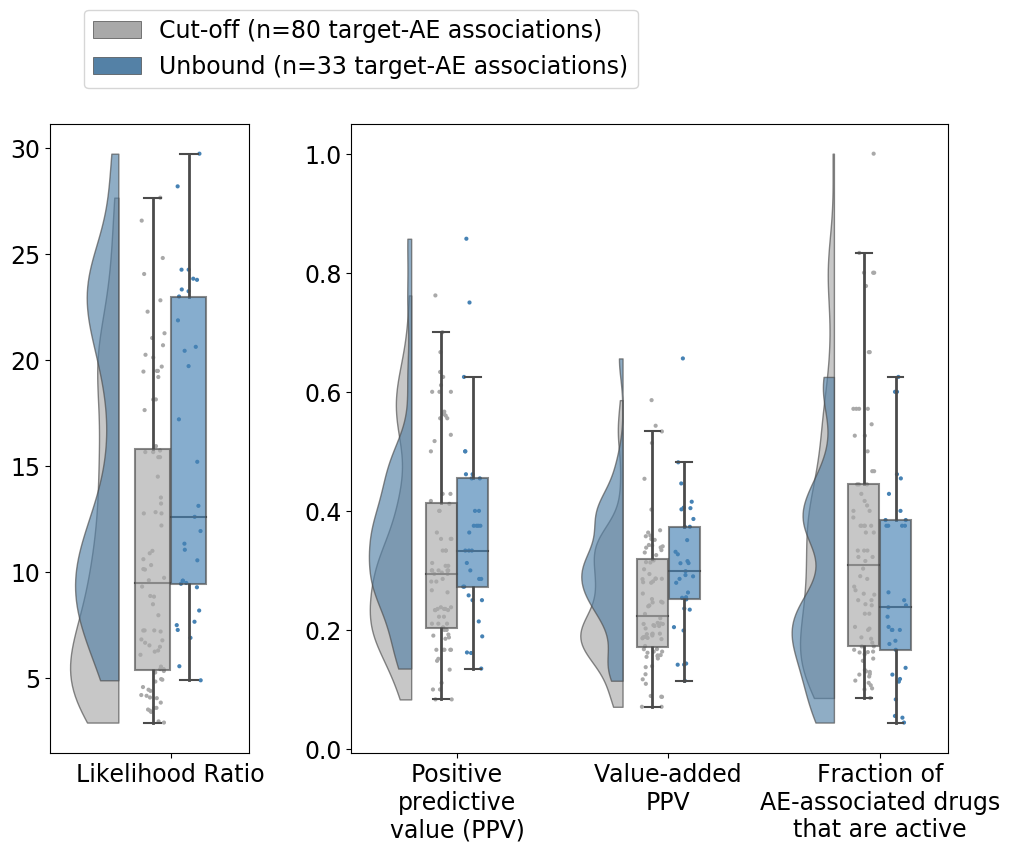

In [71]:
f, (ax2, ax1) = plt.subplots(1,2, figsize=(18,8), gridspec_kw={'width_ratios': [1,3]})

#f, ax = plt.subplots(figsize=(12, 5))
my_pal = ['darkgrey', 'steelblue']
ax=pt.RainCloud(y='values', x='variable_type', hue = 'Dataset', data = df6, palette = my_pal, bw = .3,
                 width_viol = .4, width_box= .3, ax = ax1, orient = 'v' , alpha = .65, dodge = True, hue_order=['Cut-off (n=80 target-AE associations)', 'Unbound (n=33 target-AE associations)'], box_showfliers=False)
ax=pt.RainCloud(y='values', x='variable_type', hue = 'Dataset', data = df_lr, palette = my_pal, bw = .3,
                 width_viol = .4, width_box=.3, ax = ax2, orient = 'v' , alpha = .65, dodge = True, hue_order=['Cut-off (n=80 target-AE associations)', 'Unbound (n=33 target-AE associations)'], box_showfliers=False)

f.tight_layout()

ax1.set_xlabel('')
ax1.set_ylabel('')
ax2.set_xlabel('')
ax2.set_ylabel('')

ax1.legend().set_visible(False)
ax2.legend().set_visible(False)
#ax3.legend(bbox_to_anchor=(-0.25, 1.12), ncol=2, fontsize=15)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=17, bbox_to_anchor=(0.5, 1.2), ncol=1)


plt.savefig(basedir + f'/analysis/results/overarching/Cutoff_vs_unbound_known_safety_assoc_sign_raincloud.png', bbox_inches='tight', dpi=150)